### Análise dos Covenants Contábeis divulgados pelas empresas listadas na B3 (2010 a 2022)

In [1]:
## bibliotecas usadas
import pandas as pd
import numpy as np
import unicodedata
import os
import re
# visualização
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
# análise
from concurrent.futures import ThreadPoolExecutor
from rapidfuzz import fuzz, process



### A análise começou com a coleta manual das notas explicativas publicadas pelas empresas no site da B3 Investidor, como também da Comissão de Valores Mobiliários (CVM).
Após coleta fiz um script para ler todos os pdfs (disponível no github: `link`) e separar em uma pasta todos que citaram covenants ou cláusulas restritivas.

In [2]:
# empresas_df = pd.read_excel("M:\{estudos}\Python\Covenants-Contabeis\Empresas_com_covenants.xlsx")
empresas_df = pd.read_excel("C:\{estudos}\Covenants - pibic\Covenants-Contabeis\Empresas_com_covenants.xlsx")
empresas_df.head()

<>:2: SyntaxWarning: invalid escape sequence '\{'
<>:2: SyntaxWarning: invalid escape sequence '\{'
C:\Users\PPGCC\AppData\Local\Temp\ipykernel_12220\970596658.py:2: SyntaxWarning: invalid escape sequence '\{'
  empresas_df = pd.read_excel("C:\{estudos}\Covenants - pibic\Covenants-Contabeis\Empresas_com_covenants.xlsx")


,Empresa,Quantidade de Anos
0,Hidrovias do Brasil,11
1,Ambipar Participacoes e Empreendimentos,4
2,Plano & Plano Desenvolvimento Imobiliario SA,4
3,Renner,13
4,B3 SA Brasil Bolsa Balcao,3


In [30]:
empresas_df

,Empresa,Quantidade de Anos
0,Hidrovias do Brasil,11
1,Ambipar Participacoes e Empreendimentos,4
2,Plano & Plano Desenvolvimento Imobiliario SA,4
3,Renner,13
4,B3 SA Brasil Bolsa Balcao,3
...,...,...
277,CTEEP - Companhia de Transmissao de Energia El...,13
278,Lwsa,4
279,BRF SA,6
280,Bradesco,2


In [3]:
empresas_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282 entries, 0 to 281
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Empresa             282 non-null    object
 1   Quantidade de Anos  282 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 4.5+ KB


### Selecionando agora a base de dados da análise manual
Empresas que citaram termos como "covenants" ou cláusulas "restritivas" e foram submetidas a análise manual das notas explicativas coletadas.

### Dicionário de Variáveis — Base de Análise Manual dos Covenants

Esta base contém informações extraídas manualmente das notas explicativas de empresas que mencionaram termos como **"covenants"** ou cláusulas **"restritivas"**. As empresas listadas passaram por um processo de verificação e categorização quanto à existência e divulgação dessas cláusulas.

| Coluna                               | Descrição |
|-------------------------------------|-----------|
| **EMPRESA**                         | Nome padronizado da empresa analisada (em letras maiúsculas e sem espaços extras). |
| **ANO**                             | Ano em que foi feita a análise da nota explicativa da empresa. |
| **POSSUI COVENANT**                 | Indica se a empresa possui cláusulas financeiras restritivas (covenants). Valores possíveis: `Sim`, `Não`, `Não encontrado`. |
| **DIVULGOU**                        | Indica se a empresa divulgou informações detalhadas sobre os covenants identificados. Valores possíveis: `Sim`, `Parcial`, `Não`. |
| **Debenture ou Empréstimos e financiamento** | Tipo de contrato relacionado ao covenant. Informa se o covenant foi associado a **debêntures**, **empréstimos e financiamentos** ou outro tipo de instrumento financeiro. |
| **Índice Utilizado**                | Índice financeiro citado na cláusula. Pode ser, por exemplo, `Dívida Líquida/EBITDA`, `Cobertura de Juros`, `Liquidez Corrente`, etc. |
| **Limite**                          | Valor de referência imposto pelo covenant. Pode ser um número absoluto, uma razão financeira ou um percentual. |
| **Violou?**                         | Indica se houve **descumprimento** (violação) do covenant no período analisado. Valores possíveis: `Sim`, `Não`, `Não divulgado`. |

> **Observações Importantes**:
> - Algumas empresas citam o termo **covenant** sem, de fato, detalhar a cláusula ou apresentar as condições contratuais.
> - Em alguns casos, a nota explicativa revela a **existência** do covenant, mas não especifica o **índice, limite ou situação de violação**.



In [4]:
covenants = pd.read_excel("Base Covenants.xlsx")
covenants.tail()

,EMPRESA,ANO,POSSUI COVENANT,DIVULGOU,Debenture ou Empréstimos e financiamento,Índice Utilizado,Limite,Violou?
6267,Zamp,2021.0,SIM,SIM,Debêntures,Dívida Líquida / EBITDA,menor ou igual a 3,SIM
6268,Zamp,2022.0,SIM,SIM,Debêntures,Dívida Líquida / EBITDA,menor ou igual a 3,NÃO
6269,Zamp,2022.0,SIM,SIM,Debêntures,Dívida Líquida / EBITDA,menor ou igual a 3,NÃO
6270,Zamp,2023.0,SIM,SIM,Debêntures,Dívida Líquida / EBITDA,menor ou igual a 3,NÃO
6271,Zamp,2023.0,SIM,SIM,Debêntures,Dívida Líquida / EBITDA,menor ou igual a 3,NÃO


In [5]:
covenants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6272 entries, 0 to 6271
Data columns (total 8 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   EMPRESA                                   6267 non-null   object 
 1   ANO                                       6257 non-null   float64
 2   POSSUI COVENANT                           6265 non-null   object 
 3   DIVULGOU                                  5990 non-null   object 
 4   Debenture ou Empréstimos e financiamento  5249 non-null   object 
 5   Índice Utilizado                          5209 non-null   object 
 6   Limite                                    4833 non-null   object 
 7   Violou?                                   4620 non-null   object 
dtypes: float64(1), object(7)
memory usage: 392.1+ KB


> Houve uma redução de 282 empresas para 259 na análise manual porque foi retirada empresas do setor financeiro e que disponibilizaram menos de duas notas explicativas desde 2010

In [6]:
covenants['EMPRESA'].nunique()

259

### Tratamento da base de dados

In [7]:
covenants.dropna(subset=['ANO'], inplace=True)
covenants['ANO'] = covenants['ANO'].astype(int)

# limpeza coluna 'Limite'
valores_unicos = covenants['Limite'].dropna().unique()
valores_unicos

array(['menor ou igual a 3,5', 'menor ou igual a 4,5',
       'maior ou igual a 1,25', 'maior ou igual a 1,2',
       'maior ou igual a 1,3', 'maior ou igual a 1', 'menor ou igual a 3',
       'maior ou igual a 1,1', 'menor ou igual a 2,5',
       'maior ou igual a 1,75', 'menor ou igual a 3,6',
       'maior ou igual a 1,76', 'maior ou igual a 1,5',
       'menor ou igual a 3,75', 'maior ou igual a 1,10',
       'menor ou igual a 5,6', 'maior ou igual a 1,15',
       'menor ou igual a 1,9 bi', 'menor ou igual a 338 mi',
       'menor ou igual a 840 mi', 'menor ou igual a 285 mi',
       'maior ou igual a 20%', 'menor ou igual a 50 mi',
       'maior ou igual a 41 mi', 'menor ou igual a 164 mi',
       'menor ou igual a 225 mi', 'maior ou igual a 1,20',
       'maior ou igual a 3,75', 'menor ou igual a 1,75',
       'menor ou igual a 0,6', 'maior ou igual a 3,50',
       'maior ou igual a 0,6', 'menor ou igual a 2,75',
       'menor ou igual a 2,50', 'menor ou igual a 3,0',
       'men

In [8]:
# Função para normalizar o texto (remove acentos e converte para minúsculo)
def normalizar_texto(texto):
    texto = str(texto).lower().strip()
    texto = texto.replace(',', '.')
    texto = re.sub(r'\s+', ' ', texto)  # remove espaços duplos
    texto = unicodedata.normalize('NFKD', texto).encode('ASCII', 'ignore').decode('utf-8')
    return texto

# Lista de operadores em regex
operadores_regex = (
    r'(maior ou igual a|maior ou igual|menor ou igual a|menor ou igual|'
    r'maior que|menor que|igual a)'
)

# Função principal
def extrair_limite(texto):
    if pd.isnull(texto):
        return pd.Series([None, None])

    texto_original = texto  # para verificar se tem %
    texto = normalizar_texto(texto)

    # Ignorar se houver unidades monetárias ou palavras irrelevantes
    if any(unidade in texto for unidade in ['r$', 'milhao', 'milhoes', 'mi', 'pl', 'depreciacao', 'amortizacao']):
        return pd.Series([None, None])

    # Detectar porcentagem
    tem_porcentagem = '%' in texto_original

    # Regex para operador e valor
    padrao = fr'{operadores_regex}\s*([0-9.]+)'
    match = re.search(padrao, texto)

    if match:
        operador = match.group(1).strip()
        try:
            valor = float(match.group(2))
            if tem_porcentagem:
                valor = valor / 100
            return pd.Series([operador, valor])
        except:
            return pd.Series([operador, None])

    return pd.Series([None, None])

covenants[['operador_limite', 'valor_limite']] = covenants['Limite'].apply(extrair_limite)
covenants.tail()



,EMPRESA,ANO,POSSUI COVENANT,DIVULGOU,Debenture ou Empréstimos e financiamento,Índice Utilizado,Limite,Violou?,operador_limite,valor_limite
6267,Zamp,2021,SIM,SIM,Debêntures,Dívida Líquida / EBITDA,menor ou igual a 3,SIM,menor ou igual a,3.0
6268,Zamp,2022,SIM,SIM,Debêntures,Dívida Líquida / EBITDA,menor ou igual a 3,NÃO,menor ou igual a,3.0
6269,Zamp,2022,SIM,SIM,Debêntures,Dívida Líquida / EBITDA,menor ou igual a 3,NÃO,menor ou igual a,3.0
6270,Zamp,2023,SIM,SIM,Debêntures,Dívida Líquida / EBITDA,menor ou igual a 3,NÃO,menor ou igual a,3.0
6271,Zamp,2023,SIM,SIM,Debêntures,Dívida Líquida / EBITDA,menor ou igual a 3,NÃO,menor ou igual a,3.0


In [9]:
df_empresas_setores = pd.read_excel("Setores das empresas B3.xlsx")
df_empresas_setores.columns = df_empresas_setores.columns.str.strip()
lista_nomes = df_empresas_setores["Nome da empresa no pregão"].dropna().tolist()
df_empresas_setores

,Nome da empresa no pregão,Ticker na bolsa,Setor
0,AERIS,AERI3,Bens Industriais
1,ARMAC,ARML3,Bens Industriais
2,ATMASA,ATMP3,Bens Industriais
3,AZEVEDO,AZEV4,Bens Industriais
4,AZUL,AZUL4,Bens Industriais
...,...,...,...
370,POLPAR,PPAR3,Outros
371,PROMPT PART,PRPT3,Outros
372,SUDESTE S/A,OPSE3,Outros
373,SUL 116 PART,OPTS3,Outros


In [10]:
df = covenants.copy()

df["EMPRESA"] = df["EMPRESA"].str.strip().str.upper()
df_empresas_setores["Nome da empresa no pregão"] = df_empresas_setores["Nome da empresa no pregão"].str.strip().str.upper()

def match_nome(nome, lista_nomes, threshold=60):
    melhor_match = process.extractOne(nome, lista_nomes, scorer=fuzz.partial_ratio)
    if melhor_match and melhor_match[1] >= threshold:
        return melhor_match[0]
    return None


# Aplica o fuzzy match e salva em nova coluna
with ThreadPoolExecutor() as executor:
    resultados = list(executor.map(lambda x: match_nome(x, lista_nomes), df["EMPRESA"]))
df['Empresa_Setor'] = resultados

# Remove espaços e caracteres invisíveis como \xa0 de ambas as colunas usadas no merge
df['Empresa_Setor'] = df['Empresa_Setor'].str.strip().str.replace('\xa0', '', regex=False).str.upper()
df_empresas_setores["Nome da empresa no pregão"] = df_empresas_setores["Nome da empresa no pregão"].str.strip().str.replace('\xa0', '', regex=False).str.upper()

colunas_adicionais = ["Ticker na bolsa", "Setor"]

# Faz merge usando a coluna ajustada
df_merged = pd.merge(
    df,
    df_empresas_setores[["Nome da empresa no pregão"] + colunas_adicionais],
    left_on="Empresa_Setor",
    right_on="Nome da empresa no pregão",
    how="left"
)

# Exporta e mostra os dados
df_merged.to_excel("empresas_merge_final.xlsx", index=False)
display(df_merged[["EMPRESA", "Empresa_Setor", "Setor", "Ticker na bolsa"]].head(10))

,EMPRESA,Empresa_Setor,Setor,Ticker na bolsa
0,AERIS INDUSTRIA E COMERCIO DE EQUIPAMENTOS PAR...,AERIS,Bens Industriais,AERI3
1,AERIS INDUSTRIA E COMERCIO DE EQUIPAMENTOS PAR...,AERIS,Bens Industriais,AERI3
2,AERIS INDUSTRIA E COMERCIO DE EQUIPAMENTOS PAR...,AERIS,Bens Industriais,AERI3
3,AERIS INDUSTRIA E COMERCIO DE EQUIPAMENTOS PAR...,AERIS,Bens Industriais,AERI3
4,AERIS INDUSTRIA E COMERCIO DE EQUIPAMENTOS PAR...,AERIS,Bens Industriais,AERI3
5,AES BRASIL ENERGIA,AES BRASIL,Utilidade Pública,AESB3
6,AES BRASIL ENERGIA,AES BRASIL,Utilidade Pública,AESB3
7,AES BRASIL ENERGIA,AES BRASIL,Utilidade Pública,AESB3
8,AES BRASIL ENERGIA,AES BRASIL,Utilidade Pública,AESB3
9,AES BRASIL ENERGIA,AES BRASIL,Utilidade Pública,AESB3


In [11]:
nao_encontradas = df_merged[df_merged["Setor"].isna()][["EMPRESA", "Empresa_Setor", "Ticker na bolsa"]].drop_duplicates()
print("Empresas não encontradas:", nao_encontradas.shape[0])
display(nao_encontradas.head(10))


Empresas não encontradas: 0


,EMPRESA,Empresa_Setor,Ticker na bolsa


In [12]:
df_merged.drop(columns=["Nome da empresa no pregão"], inplace=True)
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6257 entries, 0 to 6256
Data columns (total 13 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   EMPRESA                                   6257 non-null   object 
 1   ANO                                       6257 non-null   int64  
 2   POSSUI COVENANT                           6250 non-null   object 
 3   DIVULGOU                                  5975 non-null   object 
 4   Debenture ou Empréstimos e financiamento  5234 non-null   object 
 5   Índice Utilizado                          5194 non-null   object 
 6   Limite                                    4818 non-null   object 
 7   Violou?                                   4605 non-null   object 
 8   operador_limite                           4790 non-null   object 
 9   valor_limite                              4790 non-null   float64
 10  Empresa_Setor                       

In [13]:
nova_ordem = ["Empresa_Setor",
    "Setor", "ANO", "POSSUI COVENANT",
    "DIVULGOU",
    "Debenture ou Empréstimos e financiamento",
    "Índice Utilizado",
    "operador_limite",
    "valor_limite",
    "Violou?",
    "Limite",
    "Ticker na bolsa",
    "EMPRESA"]

df_merged = df_merged[nova_ordem]
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6257 entries, 0 to 6256
Data columns (total 13 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Empresa_Setor                             6257 non-null   object 
 1   Setor                                     6257 non-null   object 
 2   ANO                                       6257 non-null   int64  
 3   POSSUI COVENANT                           6250 non-null   object 
 4   DIVULGOU                                  5975 non-null   object 
 5   Debenture ou Empréstimos e financiamento  5234 non-null   object 
 6   Índice Utilizado                          5194 non-null   object 
 7   operador_limite                           4790 non-null   object 
 8   valor_limite                              4790 non-null   float64
 9   Violou?                                   4605 non-null   object 
 10  Limite                              

In [14]:
df = df_merged.copy()
df_financeiro = df[df['Setor'] == 'Financeiro'].copy()
financeiro = df_financeiro['Empresa_Setor'].unique()
print(financeiro)

df = df[df['Setor'] != 'Financeiro'].copy()
df.info()

['CIELO' 'CLEARSALE' 'ABC BRASIL' 'CSU DIGITAL' 'GENERALSHOPP' 'GP INVEST'
 'HBR REALTY' 'IGUATEMI S.A' 'INTER CO' 'ITAUSA' 'MONT ARANHA' 'MULTIPLAN'
 'SAO CARLOS' 'SIMPAR' 'SYN PROP TEC' 'IRBBRASILRE' 'WIZ CO']
<class 'pandas.core.frame.DataFrame'>
Index: 5812 entries, 0 to 6256
Data columns (total 13 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Empresa_Setor                             5812 non-null   object 
 1   Setor                                     5812 non-null   object 
 2   ANO                                       5812 non-null   int64  
 3   POSSUI COVENANT                           5805 non-null   object 
 4   DIVULGOU                                  5562 non-null   object 
 5   Debenture ou Empréstimos e financiamento  4850 non-null   object 
 6   Índice Utilizado                          4810 non-null   object 
 7   operador_limite                           

In [15]:
num_empresas = df['Empresa_Setor'].nunique()
print(f"Número de empresas na base: {num_empresas}")

Número de empresas na base: 211


#### Remover empresas que não possuem covenants ou menos de dois anos de dados para análise, como também os dados referentes a 2023

In [16]:
df_1 = df[df['POSSUI COVENANT'] == 'SIM'].copy()
df = df_1[df_1['ANO'] != 2023].copy()
print(df['ANO'].unique())


[2019 2020 2021 2022 2015 2016 2017 2018 2012 2013 2014 2010 2011]


In [17]:
contagem_anos = df.groupby('Empresa_Setor')['ANO'].nunique()

empresas_validas = contagem_anos[contagem_anos >= 2].index
df_filtrado = df[df['Empresa_Setor'].isin(empresas_validas)].copy()
df_filtrado.info()
num_empresas = df_filtrado['Empresa_Setor'].nunique()
print(f"Número de empresas na base: {num_empresas}")

<class 'pandas.core.frame.DataFrame'>
Index: 4974 entries, 0 to 6254
Data columns (total 13 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Empresa_Setor                             4974 non-null   object 
 1   Setor                                     4974 non-null   object 
 2   ANO                                       4974 non-null   int64  
 3   POSSUI COVENANT                           4974 non-null   object 
 4   DIVULGOU                                  4974 non-null   object 
 5   Debenture ou Empréstimos e financiamento  4407 non-null   object 
 6   Índice Utilizado                          4369 non-null   object 
 7   operador_limite                           4034 non-null   object 
 8   valor_limite                              4034 non-null   float64
 9   Violou?                                   3811 non-null   object 
 10  Limite                                   

In [18]:
df_filtrado['DIVULGOU'] = df_filtrado["DIVULGOU"].replace('NÂO', 'NÃO')
df_filtrado['DIVULGOU'].unique()

array(['NÃO', 'SIM'], dtype=object)

## 1. **Descrição geral da base de dados**

**Objetivo**: contextualizar o leitor sobre sua amostra.

Você pode incluir:

* Número total de empresas e anos analisados.
* Distribuição temporal da presença de covenants (`"POSSUI COVENANT"`).
* Número e proporção de empresas que divulgaram (`"DIVULGOU"`).
* Frequência dos tipos de instrumentos (debêntures vs. empréstimos).
* Frequência de presença de cláusulas com limites e índices.

📌 *Gráficos sugeridos*: histogramas, barras, timeline com linhas empilhadas.

In [19]:
# Padronizando estilo dos gráficos
plt.style.use("default")
azul_escuro = "#0d3b66"

font_titulo = {'family': 'serif', 'color': azul_escuro, 'size': 18}
font_eixos = {'family': 'serif', 'color': azul_escuro, 'size': 13}

def aplicar_estetica():
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.rcParams['axes.edgecolor'] = 'gray'
    plt.rcParams['axes.labelcolor'] = azul_escuro
    plt.rcParams['xtick.color'] = azul_escuro
    plt.rcParams['ytick.color'] = azul_escuro

In [20]:
n_empresas = df_filtrado['Empresa_Setor'].nunique()
anos_analise = df_filtrado['ANO'].nunique()

print(f"Número de empresas analisadas: {n_empresas}"
      f"\nAnos de análise: {anos_analise}")

Número de empresas analisadas: 188
Anos de análise: 13


##### 1. Distribuição temporal da presença de covenants

C:\Users\PPGCC\AppData\Local\Temp\ipykernel_12220\1656300888.py:3: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  ax = sns.countplot(


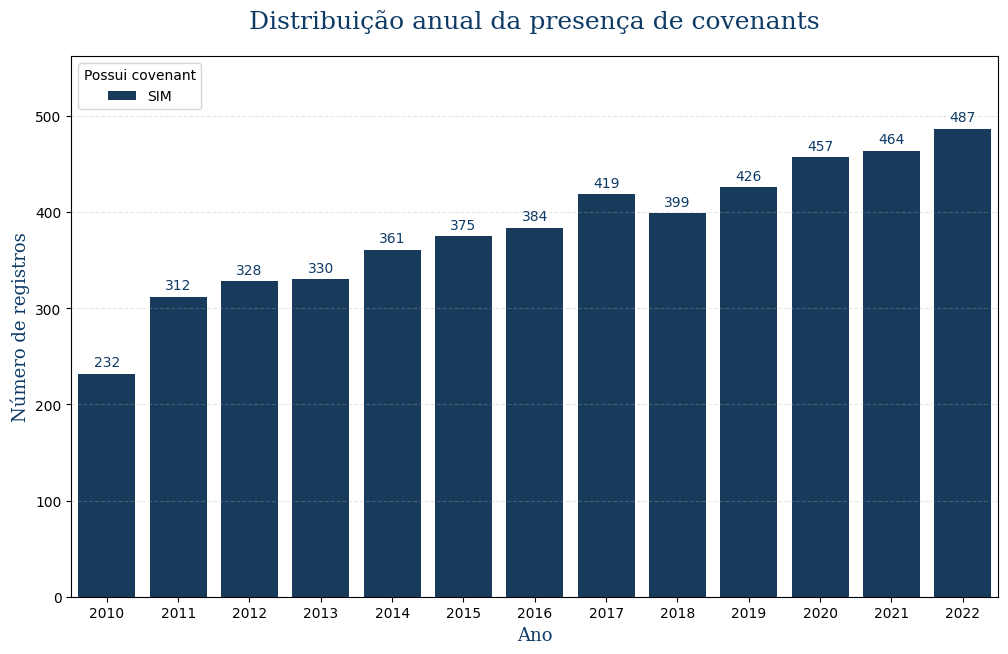

In [21]:
plt.figure(figsize=(10,6))
aplicar_estetica()
ax = sns.countplot(
    data=df_filtrado,
    x="ANO",
    hue="POSSUI COVENANT",
    palette=[azul_escuro, "#d3d3d3"],
    order=sorted(df_filtrado["ANO"].unique())
)

# 2. Loop para adicionar os rótulos em cada barra
for p in ax.patches:
    # p.get_height() é o valor da barra (a contagem)
    # Verificamos se a altura é maior que zero para não rotular barras vazias
    if p.get_height() > 0:
        ax.annotate(
            f'{int(p.get_height())}',                   
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center',                               
            va='center',                               
            xytext=(0, 8),                              
            textcoords='offset points',                
            fontsize=10,
            color=azul_escuro
        )

plt.title("Distribuição anual da presença de covenants", fontdict=font_titulo, pad=20)
plt.xlabel("Ano", fontdict=font_eixos)
plt.ylabel("Número de registros", fontdict=font_eixos)
plt.legend(title="Possui covenant", loc="upper left", frameon=True)

plt.ylim(0, ax.get_ylim()[1] * 1.1)
plt.show()

##### 2. Número e proporção de empresas que divulgaram

C:\Users\PPGCC\AppData\Local\Temp\ipykernel_12220\1234702928.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


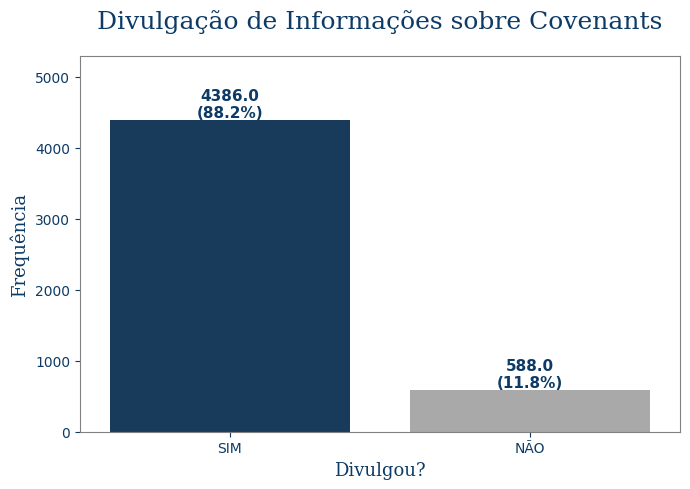

In [22]:
plt.figure(figsize=(7, 5))
ax = sns.countplot(
    data=df_filtrado,
    x="DIVULGOU",
    palette=[azul_escuro, "#a9a9a9"],
    order=df_filtrado["DIVULGOU"].value_counts().index
)
plt.title("Divulgação de Informações sobre Covenants", fontdict=font_titulo, pad=20)
plt.xlabel("Divulgou?", fontdict=font_eixos)
plt.ylabel("Frequência", fontdict=font_eixos)

# Adiciona os rótulos de dados (contagem e porcentagem)
total = len(df_filtrado['DIVULGOU'])
for p in ax.patches:
    count = p.get_height()
    percentage = f'{100 * count / total:.1f}%'
    label = f'{count}\n({percentage})'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(label, (x, y), ha='center', va='bottom', color=azul_escuro, fontweight='bold', size=11)

plt.ylim(0, ax.get_ylim()[1] * 1.15)
plt.tight_layout()
# plt.savefig("proporcao_divulgacao.png")
plt.show()

##### 3. Frequência dos Tipos de Instrumentos

C:\Users\PPGCC\AppData\Local\Temp\ipykernel_12220\2816156062.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


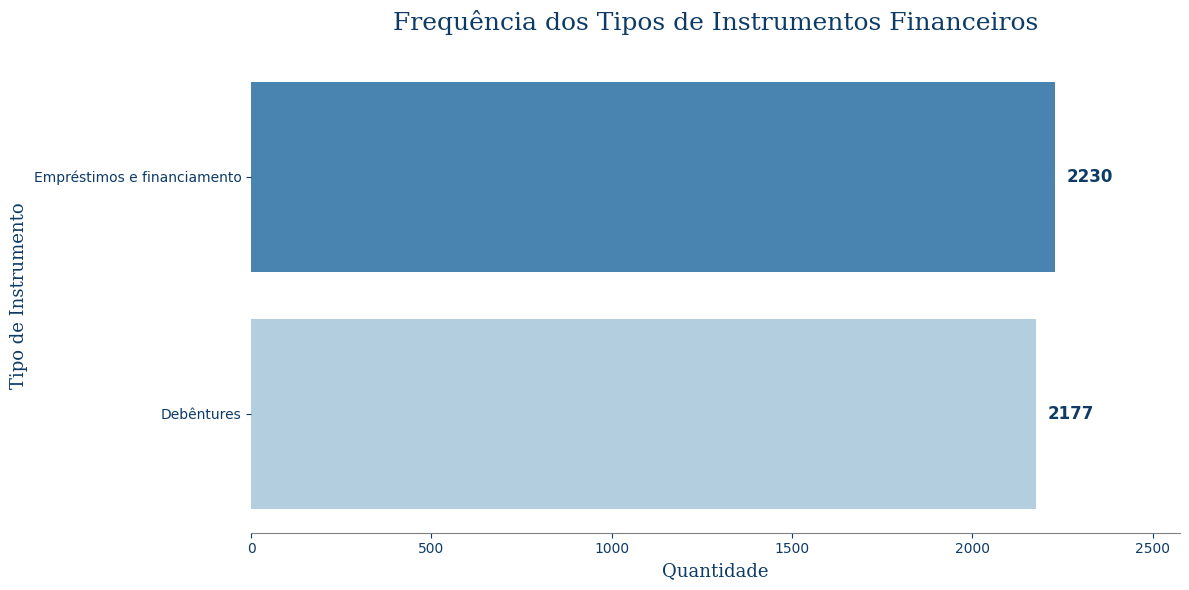

In [23]:
plt.figure(figsize=(12, 6))

ax = sns.countplot(
    data=df_filtrado.dropna(subset=["Debenture ou Empréstimos e financiamento"]),
    y="Debenture ou Empréstimos e financiamento",
    order=df_filtrado["Debenture ou Empréstimos e financiamento"].value_counts().index,
    palette=sns.color_palette("Blues_r", n_colors=df_filtrado["Debenture ou Empréstimos e financiamento"].nunique())
)

for p in ax.patches:
    width = p.get_width() 
    if width > 0:
      ax.annotate(
          f'{int(width)}',
          xy=(width, p.get_y() + p.get_height() / 2), # Posição (x,y) do texto
          xytext=(8, 0), # Deslocamento de 8 pontos para a direita
          textcoords='offset points',
          ha='left', # Alinhamento horizontal
          va='center', # Alinhamento vertical
          fontsize=12,
          color=azul_escuro,
          weight='bold'
          )

# Aumenta o limite do eixo X para dar espaço aos rótulos
plt.xlim(0, ax.get_xlim()[1] * 1.1)

plt.title("Frequência dos Tipos de Instrumentos Financeiros", fontdict=font_titulo, pad=20)
plt.xlabel("Quantidade", fontdict=font_eixos)
plt.ylabel("Tipo de Instrumento", fontdict=font_eixos)

sns.despine(left=True, bottom=False)

plt.tight_layout()
plt.show()

#### 4. Frequência de Cláusulas com Limites Definidos

C:\Users\PPGCC\AppData\Local\Temp\ipykernel_12220\1915347706.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


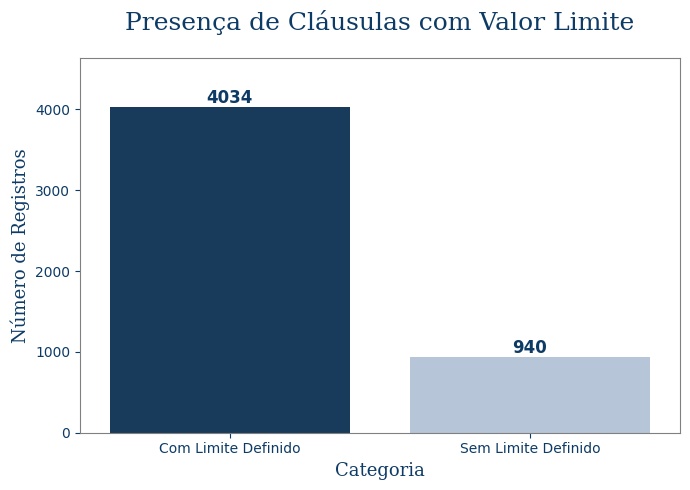

In [24]:
df_filtrado['tem_limite'] = df_filtrado['valor_limite'].notna().map({True: 'Com Limite Definido', False: 'Sem Limite Definido'})
contagem_limites = df_filtrado['tem_limite'].value_counts()

plt.figure(figsize=(7, 5))
ax = sns.barplot(
    x=contagem_limites.index,
    y=contagem_limites.values,
    palette=[azul_escuro, "#b0c4de"]
)
plt.title("Presença de Cláusulas com Valor Limite", fontdict=font_titulo, pad=20)
plt.xlabel("Categoria", fontdict=font_eixos)
plt.ylabel("Número de Registros", fontdict=font_eixos)

# Adiciona os rótulos de dados
for i, v in enumerate(contagem_limites.values):
    ax.text(i, v, str(v), ha='center', va='bottom', color=azul_escuro, fontweight='bold', size=12)

plt.ylim(0, max(contagem_limites.values) * 1.15)
plt.tight_layout()
# plt.savefig("frequencia_clausulas_limite.png")
plt.show()

##### 5. Evolução da Proporção de Covenants ao Longo do Tempo

In [25]:
# Calcula a proporção de 'SIM' e 'NÃO' para cada ano
proporcao_ano = df_possui_covenant.groupby('ANO')['POSSUI COVENANT'].value_counts(normalize=True).unstack()

# Plotagem
plt.figure(figsize=(10, 6))
ax = sns.lineplot(
    data=proporcao_ano['SIM'], # Plota apenas a linha para 'SIM'
    marker='o',
    markersize=8,
    linewidth=2.5,
    color=azul_escuro
)

# Formata o eixo Y como porcentagem
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

plt.title('Evolução da Proporção de Contratos com Covenants', fontdict=font_titulo, pad=20)
plt.xlabel('Ano', fontdict=font_eixos)
plt.ylabel('Proporção de Observações com Covenants', fontdict=font_eixos)
plt.ylim(0, 1) # Define o eixo Y de 0% a 100%
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
sns.despine()
plt.tight_layout()
plt.show()

NameError: name 'df_possui_covenant' is not defined


## 🏢 5. **Setores mais expostos a covenants**

**Com a variável `Setor` adicionada**, você pode:

* Ver a proporção de empresas por setor que têm cláusulas de covenant.
* Quais setores mais divulgam os termos?
* Quais setores têm limites mais rígidos?
* Quais setores mais violam cláusulas?

📌 *Gráficos*: barras, heatmaps, scatterplots de valor do limite × setor.

C:\Users\PPGCC\AppData\Local\Temp\ipykernel_12220\1446711462.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


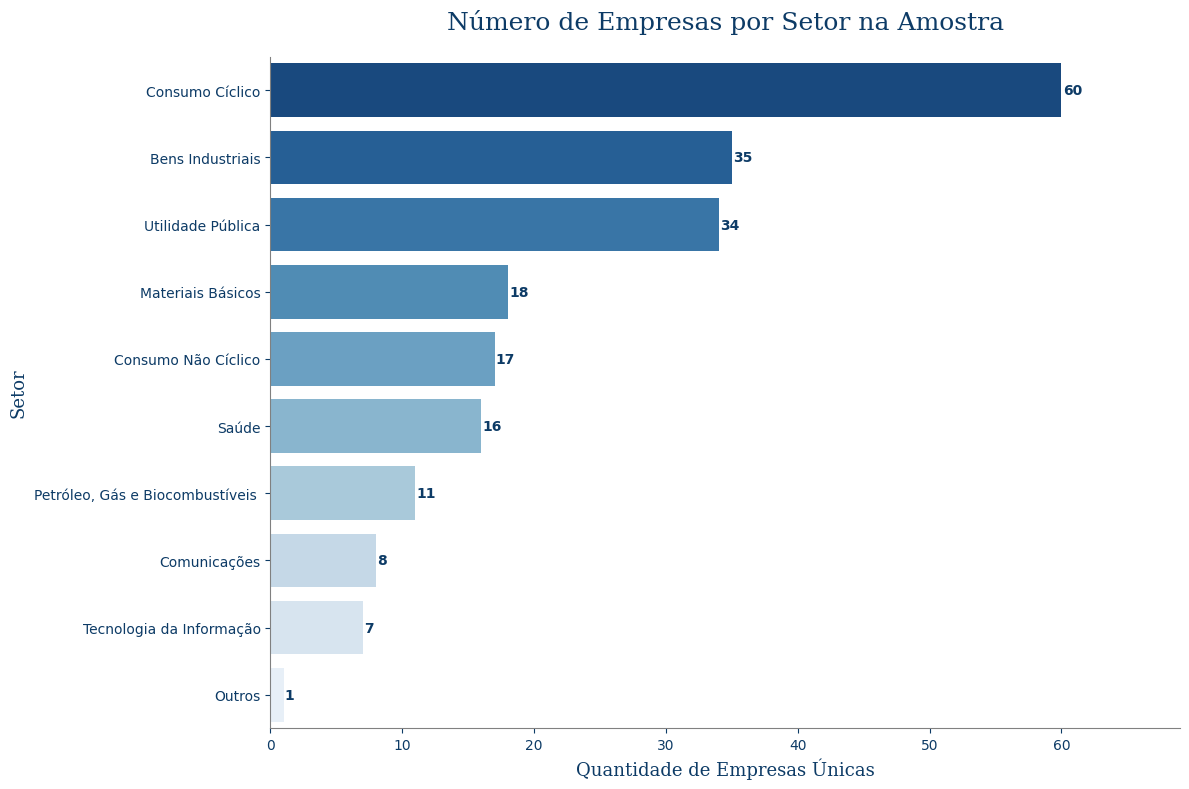

In [26]:
empresas_por_setor = df_filtrado.groupby('Setor')['EMPRESA'].nunique().sort_values(ascending=False)

plt.figure(figsize=(12, 8))
ax = sns.barplot(
    x=empresas_por_setor.values,
    y=empresas_por_setor.index,
    palette="Blues_r"
)

# Adiciona os rótulos de dados
for i, v in enumerate(empresas_por_setor.values):
    ax.text(v + 0.1, i, str(v), color=azul_escuro, va='center', fontweight='bold')

plt.title('Número de Empresas por Setor na Amostra', fontdict=font_titulo, pad=20)
plt.xlabel('Quantidade de Empresas Únicas', fontdict=font_eixos)
plt.ylabel('Setor', fontdict=font_eixos)
plt.xlim(0, empresas_por_setor.max() * 1.15) # Espaço extra para os rótulos
sns.despine()
plt.tight_layout()
plt.show()

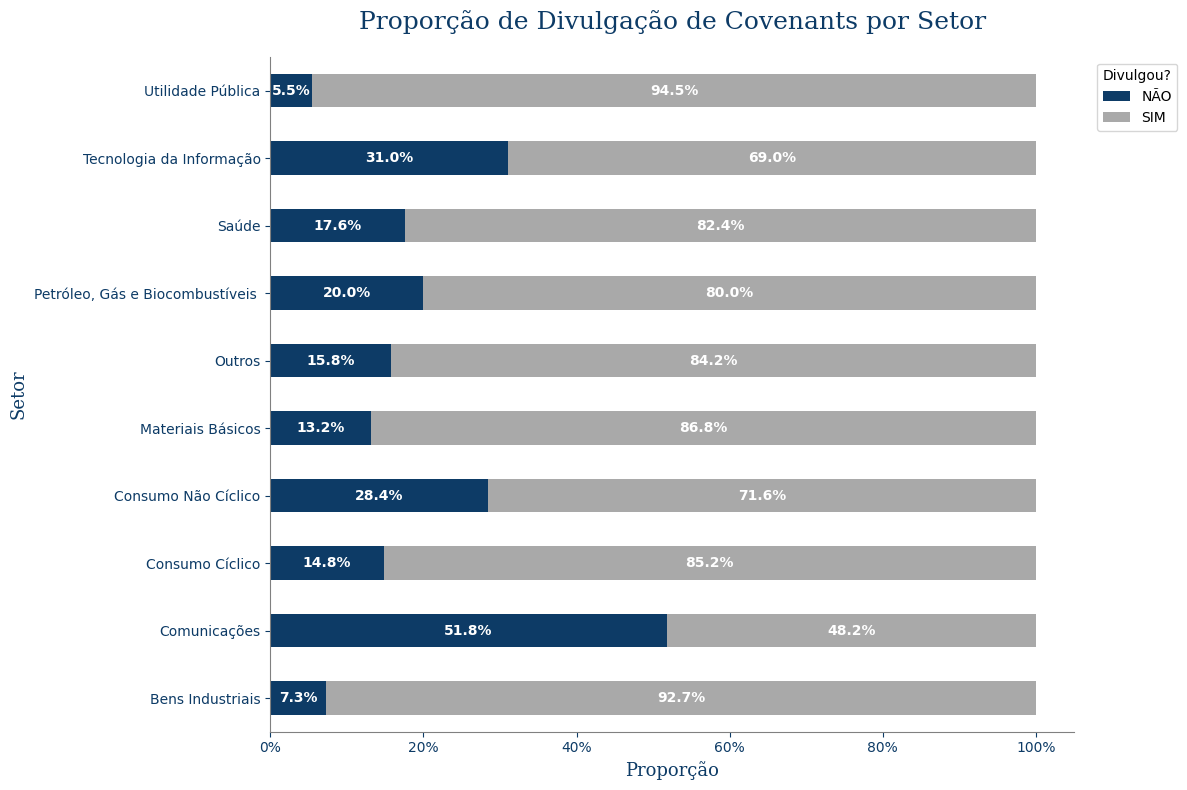

In [27]:
# Cria uma tabela de contingência
tabela_divulgacao = pd.crosstab(df_filtrado['Setor'], df_filtrado['DIVULGOU'])

# Normaliza a tabela para que a soma de cada linha seja 1 (100%)
tabela_norm = tabela_divulgacao.div(tabela_divulgacao.sum(axis=1), axis=0)

# Plotagem
ax = tabela_norm.plot(
    kind='barh',
    stacked=True,
    figsize=(12, 8),
    color=[azul_escuro, '#a9a9a9'] # 'SIM' em azul, 'NÃO' em cinza
)

# Adiciona os rótulos de porcentagem
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    if width > 0:
        ax.text(x + width/2,
                y + height/2,
                f'{width:.1%}', # Formata como porcentagem
                ha='center',
                va='center',
                color='white',
                fontweight='bold')

plt.title('Proporção de Divulgação de Covenants por Setor', fontdict=font_titulo, pad=20)
plt.xlabel('Proporção', fontdict=font_eixos)
plt.ylabel('Setor', fontdict=font_eixos)
plt.legend(title='Divulgou?', bbox_to_anchor=(1.02, 1), loc='upper left') # Legenda fora do gráfico
ax.xaxis.set_major_formatter(plt.FuncFormatter('{:.0%}'.format)) # Formata o eixo X como %
sns.despine()
plt.tight_layout()
plt.show()

Quais Setores Têm Limites Mais Rígidos?
Objetivo: Comparar a "rigidez" dos covenants entre os setores. Para fazer isso de forma justa, vamos focar no índice mais comum: Dívida Líquida / EBITDA, onde um limite menor significa uma cláusula mais rígida.

C:\Users\PPGCC\AppData\Local\Temp\ipykernel_12220\550864985.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


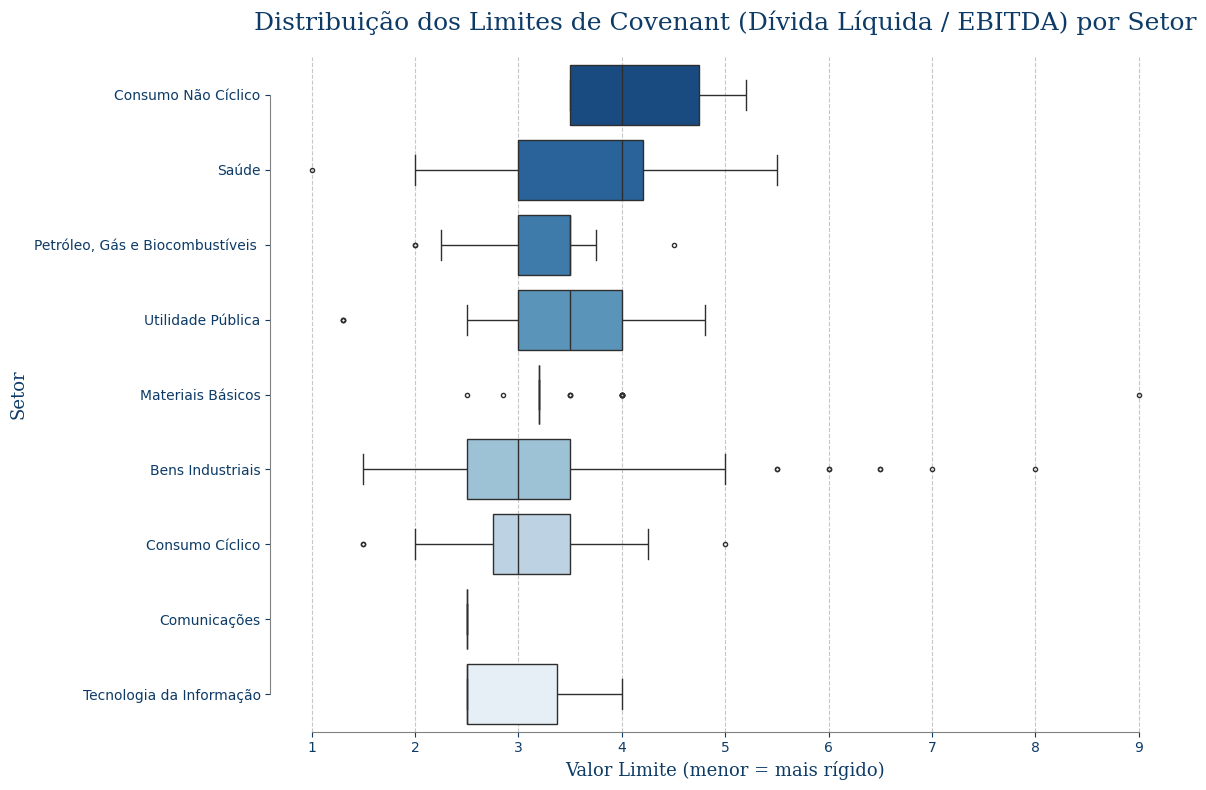

In [28]:
df_limites_dl_ebitda = df_filtrado[
    (df_filtrado['Índice Utilizado'] == 'Dívida Líquida / EBITDA') &
    (df_filtrado['valor_limite'].notna()) &
    (df_filtrado['valor_limite'] < 10) # Filtro para remover outliers que poluem o gráfico
].copy()

# 2. Calcular a mediana por setor para ordenar o gráfico
medianas_por_setor = df_limites_dl_ebitda.groupby('Setor')['valor_limite'].median().sort_values(ascending=False)

# 3. Plotagem do Box Plot
plt.figure(figsize=(12, 8))
sns.boxplot(
    data=df_limites_dl_ebitda,
    y='Setor',
    x='valor_limite',
    order=medianas_por_setor.index, # Ordena os setores pela mediana
    palette='Blues_r',
    fliersize=3 # Tamanho dos marcadores de outliers
)

plt.title('Distribuição dos Limites de Covenant (Dívida Líquida / EBITDA) por Setor', fontdict=font_titulo, pad=20)
plt.xlabel('Valor Limite (menor = mais rígido)', fontdict=font_eixos)
plt.ylabel('Setor', fontdict=font_eixos)
plt.grid(axis='x', linestyle='--', alpha=0.7)
sns.despine(trim=True)
plt.tight_layout()
plt.show()

Quais Setores Mais Violam Cláusulas?
Objetivo: Identificar se existe uma concentração de violações de covenants em determinados setores.

Metodologia: Para uma comparação justa, não podemos usar a contagem absoluta de violações. Precisamos calcular a taxa ou proporção de violações por setor.

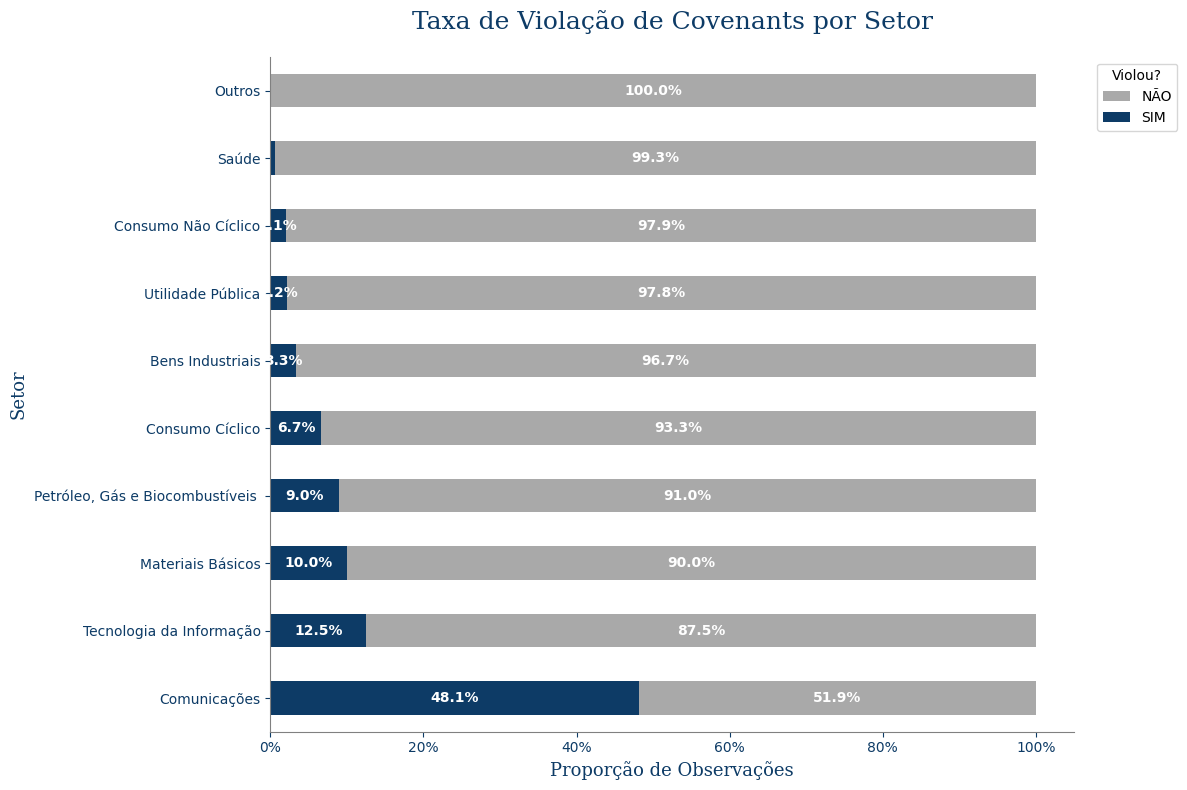

In [29]:
df_violacao = df_filtrado.dropna(subset=['Violou?'])

# 2. Criar uma tabela de contingência
tabela_violacao = pd.crosstab(df_violacao['Setor'], df_violacao['Violou?'])

# 3. Normalizar a tabela para que a soma de cada linha seja 1 (100%)
# Adicionamos colunas 'SIM' ou 'NÃO' com 0 se não existirem para evitar erros
if 'SIM' not in tabela_violacao.columns: tabela_violacao['SIM'] = 0
if 'NÃO' not in tabela_violacao.columns: tabela_violacao['NÃO'] = 0
tabela_norm_violacao = tabela_violacao.div(tabela_violacao.sum(axis=1), axis=0).sort_values(by='SIM', ascending=False)


# 4. Plotagem do Gráfico de Barras Empilhadas
ax = tabela_norm_violacao[['SIM', 'NÃO']].plot(
    kind='barh',
    stacked=True,
    figsize=(12, 8),
    color=[azul_escuro, '#a9a9a9']
)

# Adiciona os rótulos de porcentagem
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    if width > 0.02: # Só mostra o rótulo se for minimamente relevante
        ax.text(x + width/2,
                y + height/2,
                f'{width:.1%}',
                ha='center',
                va='center',
                color='white',
                fontweight='bold')

plt.title('Taxa de Violação de Covenants por Setor', fontdict=font_titulo, pad=20)
plt.xlabel('Proporção de Observações', fontdict=font_eixos)
plt.ylabel('Setor', fontdict=font_eixos)

# Formata o eixo X como porcentagem
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))

# Ajusta a legenda
handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels), title='Violou?', bbox_to_anchor=(1.02, 1), loc='upper left')

# Os setores no topo do gráfico são aqueles com a maior proporção de violações (a barra azul escura, representando 'SIM', será maior). Este gráfico aponta claramente os setores que, na sua amostra, tiveram mais dificuldade em cumprir suas obrigações contratuais.

sns.despine()
plt.tight_layout()
plt.show()



---

## 🏗️ 2. **Análise dos tipos de índices utilizados**

**Objetivo**: entender os indicadores financeiros mais usados como base para os covenants.

Analise:

* Frequência de cada valor em `"Índice Utilizado"` (ex: dívida/EBITDA, cobertura de juros, etc).
* Agrupamento por tipo de índice (liquidez, rentabilidade, endividamento, etc).
* Como esses índices variam por setor.

📌 *Gráficos*: gráfico de barras horizontais com os índices mais comuns.

---

## 📊 3. **Distribuição dos limites numéricos**

**Objetivo**: avaliar os **valores definidos nos contratos** como critérios para quebra de covenant.

* Distribuição dos valores numéricos extraídos (`valor_limite`) por índice.
* Diferença nos limites definidos por setor.
* Comparar limites para empresas que **violaram** e **não violaram**.

📌 *Gráficos*: boxplots por índice, por setor, por status de violação.

---

## 🚨 4. **Análise de violação**

**Objetivo**: identificar padrão de violação contratual.

* Percentual de empresas que violaram covenants (`"Violou?" == 'sim'`).
* Comparar com a média do índice (se tiver os valores reais dos indicadores).
* Quais índices têm maior taxa de violação?
* Existe associação entre tipo de índice e violação?

📌 *Gráficos*: barras empilhadas, heatmaps.

---


---

## 📅 6. **Evolução temporal**

**Se tiver a variável `ANO` bem preenchida**:

* Evolução do uso de covenants ao longo do tempo.
* Mudança nos limites definidos ano a ano.
* Tendência de divulgação e violação.

📌 *Gráficos*: linhas por ano, área acumulada, barras temporais.

---

## 🔍 7. **Casos qualitativos especiais**

Você pode mencionar ou classificar manualmente:

* Limites com condições não numéricas (ex: `"menor ou igual a 75% da depreciação"`).
* Cláusulas que envolvem múltiplos critérios (`"maior ou igual a 1,5 ou menor que 0"`).
* Casos com valor em R\$, milhões, ou pagamentos parcelados.

📌 *Sugestão*: construir uma tabela de exemplos e agrupar por "não padronizável", "qualitativo", "financeiro monetário", etc.

---

## 📚 8. **Discussão econométrica (opcional)**

Se tiver tempo e dados complementares:

* Você pode rodar uma regressão para **estimar a probabilidade de violação**, com variáveis como:

  * tipo de índice
  * setor
  * ano
  * valor do limite
  * tipo de instrumento (debênture vs empréstimo)

📌 *Modelo sugerido*: regressão logística.

---

## ✨ Exemplos de perguntas para seu artigo

* "Quais índices são mais usados como covenants nas empresas listadas da B3?"
* "Há setores que enfrentam cláusulas mais restritivas?"
* "Os limites definidos nos contratos mudaram com o tempo?"
* "As cláusulas são efetivas? Há alto índice de violação?"
* "Existe alguma evidência de que empresas com covenants apresentam melhor governança?
